# import

In [93]:
import pandas as pd
import xml.etree.ElementTree as ET
from astropy.io import fits

from astropy.io.votable import parse
from astropy.io.votable import parse_single_table
from astropy.io.votable.tree import VOTableFile, Resource, Table, Field
from astropy.io import fits


from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr#

import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import cm

from collections import OrderedDict
from adjustText import adjust_text

%matplotlib inline
%config InlineBackend.figure_format='svg'
# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
#rcParams["savefig.dpi"] = 300

In [90]:
#from adjustText import adjust_text
import matplotlib as mpl
def set_ax_tick(ax):
    ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on',)
    ax.xaxis.set_tick_params(which='minor', size=5, width=2, direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=5, width=2, direction='in', right='on')

def set_ax_locator(ax,xma=1,xmi=0.2,yma=1,ymi=0.2):
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(xma))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(xmi))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(yma))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(ymi)) 

In [91]:
def drop_index(data):
    data=data.reset_index(drop=True)
    return data

# calc_power_law

In [200]:
from scipy.optimize import least_squares, curve_fit
from scipy.stats import f

In [ ]:
def calc_power_law(freq,S0,alpha):
    S = S0 * (freq) ** alpha
    return S

def alpha_calc(data,freq_label='frequency',flux_label='flux',rms_label='rms'):    
    #Get lightcurve values
    freqs = data[freq_label]
    flux = data[flux_label]
    flux_errs = data[rms_label]
    
    #Use the scipy curve_fit algorithm to calculate the best fit value
    popt, pcov = curve_fit(calc_power_law, freqs, flux ,sigma=flux_errs, p0=(50,-0.61),absolute_sigma=True)
    
    alpha = popt[1] #Best-fit spectral index
    alpha_err = np.sqrt(np.diag(pcov))[1] #Uncertainty in alpha
    
    return alpha, alpha_err

def scale_data(data, alpha, alpha_err, ref_freq=5.0,freq_label='frequency',flux_label='flux',rms_label='rms'):#
    #calculate a scaling factor for the flux density and uncertainty
    f_scale = (ref_freq/data[freq_label])**alpha
    rms_scale = np.abs(f_scale*np.log(ref_freq/data[freq_label])*alpha_err)
    
    #scale the flux and uncertainty - don't forget to add errors in quadrature
    scaled_flux = data[flux_label] * f_scale
    scaled_rms = np.abs(scaled_flux) * np.sqrt((data[rms_label]/data[flux_label])**2 + (rms_scale/f_scale)**2)
    
    #Add two new columns to the data
    data['scaled_flux'] = scaled_flux
    data['scaled_rms'] = scaled_rms
    
    return data

In [ ]:
sel_data = data#[data['delta_t'] == 162.89]
alpha, alpha_err = alpha_calc(sel_data)
print("alpha = %.2f+/-%.2f"%(alpha, alpha_err))

In [ ]:
def plot_data(ax, sm, data, scaled=False, **kwargs):
    telescope_marker_dict = {'VLA':'s', 'ATCA':'o', 'GMRT':'d'}
    
    
    for row in data:
        #Loop over each row of the data, set the marker colour based on frequency and the marker style based on telescope
        freq = row['frequency']
        colorval = sm.to_rgba(freq) #Set the marker colour based on observing frequency
        
        telescope = row['telescope']
        marker = telescope_marker_dict[telescope] #Set the marker based on telescope
        
        #Are we plotting the original flux density values? Or the scaled values?
        if scaled:
            flux = row['scaled_flux']
            rms = row['scaled_rms']
        else:
            flux = row['flux']
            rms = row['rms']
        
        ax.errorbar(row['delta_t'], flux, rms, linestyle='', marker=marker, c=colorval, **kwargs) #Plot the flux density (with uncertainty) on the provided axis
    return

def cmap_setup(cmap='viridis', min_freq=0, max_freq=17):
    '''
    This function will set up a scalar map for you to colour your markers by frequency
    '''
    freq_cmap = plt.cm.get_cmap(cmap)
    
    cNorm  = colors.Normalize(vmin=min_freq, vmax=max_freq)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
    sm = scalarMap
    sm._A = []
    
    return sm    
    
def make_plot(data, scaled=False, model=None, params=None, tvals=np.arange(10,400), plot_models=False):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    
    #Get the scalar map, plot the data using the plot_data function above
    sm = cmap_setup()
    plot_data(ax, sm, data, scaled=scaled)
    
    
    #Set up a colourbar
    cbar = fig.colorbar(sm,fraction=0.046, pad=0.04)
    cbar.set_label('Frequency (GHz)')
    
    #Set axis scales to log
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    #Label axes, set axis limits etc.
    ax.set_xlabel('Time (days)')
    if scaled:
        ax.set_ylabel('Scaled Flux Density ($\mu$Jy)')
    else:
        ax.set_ylabel('Flux Density ($\mu$Jy)')
        
    if model:
        plot_model(model, params, tvals, ax)
    
    if plot_models:
        plot_physical_models(ax)
    
    ax.set_xlim(10,300)
    
make_plot(data)

## cosmology

In [63]:
from astropy.cosmology import FlatLambdaCDM,Planck13,Planck15,z_at_value
from astropy import units as u
from astropy.cosmology import LambdaCDM

#cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
cosmo = LambdaCDM(H0=73, Om0=0.27, Ode0=0.73)
#cosmo=FlatLambdaCDM(H0=73,Om0=0.3)

# Spectral Variability of Radio Sources at Low Frequencies 2012.01842.pdf

In [106]:
#from astropy.io.votable import parse_single_table
from astropy.table import Table

mwa_spectral_var_path='/Users/brettlv/blog/IHEP_sync/data/data_mwa/Spectral_variability_of_radio_sources_at_low_frequencies——staa3795_supplemental_files/suuplementary_table_master_population.votable'
#mwa_spectral_var_votable = parse(mwa_spectral_var_path)
#mwa_spectral_var_table = parse_single_table(mwa_spectral_var_path).to_table()
mwa_spectral_var_table = Table.read(mwa_spectral_var_path)

In [107]:
mwa_spectral_var_table

GLEAM_Name,RAhms,Decdms,RAJ2000,e_RAJ2000,DEJ2000,e_DEJ2000,int_flux_wide_yr1,e_int_flux_wide_yr1,local_rms_wide_yr1,a_wide_yr1,b_wide_yr1,psf_a_wide_yr1,psf_b_wide_yr1,int_flux_wide_yr2,e_int_flux_wide_yr2,local_rms_wide_yr2,a_wide_yr2,b_wide_yr2,psf_a_wide_yr2,psf_b_wide_yr2,local_rms_107_yr1,S_107_yr1,e_S_107_yr1,local_rms_115_yr1,S_115_yr1,e_S_115_yr1,local_rms_123_yr1,S_123_yr1,e_S_123_yr1,local_rms_130_yr1,S_130_yr1,e_S_130_yr1,local_rms_143_yr1,S_143_yr1,e_S_143_yr1,local_rms_150_yr1,S_150_yr1,e_S_150_yr1,local_rms_158_yr1,S_158_yr1,e_S_158_yr1,local_rms_166_yr1,S_166_yr1,e_S_166_yr1,local_rms_174_yr1,S_174_yr1,e_S_174_yr1,local_rms_181_yr1,S_181_yr1,e_S_181_yr1,local_rms_189_yr1,S_189_yr1,e_S_189_yr1,local_rms_197_yr1,S_197_yr1,e_S_197_yr1,local_rms_204_yr1,S_204_yr1,e_S_204_yr1,local_rms_212_yr1,S_212_yr1,e_S_212_yr1,local_rms_220_yr1,S_220_yr1,e_S_220_yr1,local_rms_227_yr1,S_227_yr1,e_S_227_yr1,local_rms_107_yr2,S_107_yr2,e_S_107_yr2,local_rms_115_yr2,S_115_yr2,e_S_115_yr2,local_rms_123_yr2,S_123_yr2,e_S_123_yr2,local_rms_130_yr2,S_130_yr2,e_S_130_yr2,local_rms_143_yr2,S_143_yr2,e_S_143_yr2,local_rms_150_yr2,S_150_yr2,e_S_150_yr2,local_rms_158_yr2,S_158_yr2,e_S_158_yr2,local_rms_166_yr2,S_166_yr2,e_S_166_yr2,local_rms_174_yr2,S_174_yr2,e_S_174_yr2,local_rms_181_yr2,S_181_yr2,e_S_181_yr2,local_rms_189_yr2,S_189_yr2,e_S_189_yr2,local_rms_197_yr2,S_197_yr2,e_S_197_yr2,local_rms_204_yr2,S_204_yr2,e_S_204_yr2,local_rms_212_yr2,S_212_yr2,e_S_212_yr2,local_rms_220_yr2,S_220_yr2,e_S_220_yr2,local_rms_227_yr2,S_227_yr2,e_S_227_yr2,S_076,e_S_076,S_084,e_S_084,S_092,e_S_092,S_099,e_S_099,S_tgss,e_S_tgss,S_mrc,S_sumss,S_nvss,S_vlssr,alpha_low_yr1,e_alpha_low_yr1,alpha_high_yr1,e_alpha_high_yr1,quad_curve_yr1,e_quad_curve_yr1,redchisq_low_yr1,redchisq_high_yr1,redchisq_quad_yr1,alpha_low_yr2,e_alpha_low_yr2,alpha_high_yr2,e_alpha_high_yr2,quad_curve_yr2,e_quad_curve_yr2,redchisq_low_yr2,redchisq_high_yr2,redchisq_quad_yr2,VIP,MOSS,variable_flag,peaked_spectrum_source_flag,persistent_pss_flag,MOSS_class,pss_class_yr1,pss_class_yr2,RAJ2000_NVSS,DEJ2000_NVSS,RA_WISE,Dec_WISE,w1mpro,w2mpro,w3mpro,w4mpro,Class,z
,,,,,,,Jy,Jy,Jy.beam-1,"""","""","""","""",Jy,Jy,Jy.beam-1,"""","""","""","""",Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,,
str20,str11,str12,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float

## mwa_spectral_var_table.colnames

In [108]:
mwa_spectral_var_table.colnames

['GLEAM_Name',
 'RAhms',
 'Decdms',
 'RAJ2000',
 'e_RAJ2000',
 'DEJ2000',
 'e_DEJ2000',
 'int_flux_wide_yr1',
 'e_int_flux_wide_yr1',
 'local_rms_wide_yr1',
 'a_wide_yr1',
 'b_wide_yr1',
 'psf_a_wide_yr1',
 'psf_b_wide_yr1',
 'int_flux_wide_yr2',
 'e_int_flux_wide_yr2',
 'local_rms_wide_yr2',
 'a_wide_yr2',
 'b_wide_yr2',
 'psf_a_wide_yr2',
 'psf_b_wide_yr2',
 'local_rms_107_yr1',
 'S_107_yr1',
 'e_S_107_yr1',
 'local_rms_115_yr1',
 'S_115_yr1',
 'e_S_115_yr1',
 'local_rms_123_yr1',
 'S_123_yr1',
 'e_S_123_yr1',
 'local_rms_130_yr1',
 'S_130_yr1',
 'e_S_130_yr1',
 'local_rms_143_yr1',
 'S_143_yr1',
 'e_S_143_yr1',
 'local_rms_150_yr1',
 'S_150_yr1',
 'e_S_150_yr1',
 'local_rms_158_yr1',
 'S_158_yr1',
 'e_S_158_yr1',
 'local_rms_166_yr1',
 'S_166_yr1',
 'e_S_166_yr1',
 'local_rms_174_yr1',
 'S_174_yr1',
 'e_S_174_yr1',
 'local_rms_181_yr1',
 'S_181_yr1',
 'e_S_181_yr1',
 'local_rms_189_yr1',
 'S_189_yr1',
 'e_S_189_yr1',
 'local_rms_197_yr1',
 'S_197_yr1',
 'e_S_197_yr1',
 'local_rms_20

In [109]:
mwa_spectral_var_table.add_column(0,name='select')

# mwa_spectral_var_path_dir

In [5]:
mwa_spectral_var_path_dir='/Users/brettlv/blog/IHEP_sync/data/data_mwa/Spectral_variability_of_radio_sources_at_low_frequencies——staa3795_supplemental_files/Appendix/'


## mwa_spectral_var_list

In [7]:
import os
mwa_spectral_var_list=[]
names=os.listdir(mwa_spectral_var_path_dir)
for i in names:
    if i.endswith('pdf'):
        mwa_spectral_var_list.append(i[:-4])

In [27]:
len(mwa_spectral_var_list)

323

In [8]:
mwa_spectral_var_list

['GLEAM_J000353-382707',
 'GLEAM_J000402-101507',
 'GLEAM_J000404-114858',
 'GLEAM_J000533-252819',
 'GLEAM_J000619-424524',
 'GLEAM_J001052-415316',
 'GLEAM_J001502-181238',
 'GLEAM_J001513-472706',
 'GLEAM_J001525-361620',
 'GLEAM_J001942-303118',
 'GLEAM_J002223-070230',
 'GLEAM_J002251-435218',
 'GLEAM_J002257-464809',
 'GLEAM_J002523-222744',
 'GLEAM_J002552-144111',
 'GLEAM_J003119-165202',
 'GLEAM_J003152-311437',
 'GLEAM_J003244-144112',
 'GLEAM_J003246-293107',
 'GLEAM_J003454-230328',
 'GLEAM_J003616-430939',
 'GLEAM_J004209-441404',
 'GLEAM_J004342-033142',
 'GLEAM_J004451-492745',
 'GLEAM_J004644-052157',
 'GLEAM_J004839-294718',
 'GLEAM_J005021-045218',
 'GLEAM_J005052-442841',
 'GLEAM_J005315-070232',
 'GLEAM_J005351-491402',
 'GLEAM_J005409-475208',
 'GLEAM_J005446-090207',
 'GLEAM_J005459-302204',
 'GLEAM_J005511-121754',
 'GLEAM_J005754-493154',
 'GLEAM_J010316-322550',
 'GLEAM_J010626-271803',
 'GLEAM_J010656-094638',
 'GLEAM_J010834-103346',
 'GLEAM_J010957-331336',


In [51]:
len(mwa_spectral_var_table)

21558

In [23]:
mwa_spectral_var_table.colnames

['GLEAM_Name',
 'RAhms',
 'Decdms',
 'RAJ2000',
 'e_RAJ2000',
 'DEJ2000',
 'e_DEJ2000',
 'int_flux_wide_yr1',
 'e_int_flux_wide_yr1',
 'local_rms_wide_yr1',
 'a_wide_yr1',
 'b_wide_yr1',
 'psf_a_wide_yr1',
 'psf_b_wide_yr1',
 'int_flux_wide_yr2',
 'e_int_flux_wide_yr2',
 'local_rms_wide_yr2',
 'a_wide_yr2',
 'b_wide_yr2',
 'psf_a_wide_yr2',
 'psf_b_wide_yr2',
 'local_rms_107_yr1',
 'S_107_yr1',
 'e_S_107_yr1',
 'local_rms_115_yr1',
 'S_115_yr1',
 'e_S_115_yr1',
 'local_rms_123_yr1',
 'S_123_yr1',
 'e_S_123_yr1',
 'local_rms_130_yr1',
 'S_130_yr1',
 'e_S_130_yr1',
 'local_rms_143_yr1',
 'S_143_yr1',
 'e_S_143_yr1',
 'local_rms_150_yr1',
 'S_150_yr1',
 'e_S_150_yr1',
 'local_rms_158_yr1',
 'S_158_yr1',
 'e_S_158_yr1',
 'local_rms_166_yr1',
 'S_166_yr1',
 'e_S_166_yr1',
 'local_rms_174_yr1',
 'S_174_yr1',
 'e_S_174_yr1',
 'local_rms_181_yr1',
 'S_181_yr1',
 'e_S_181_yr1',
 'local_rms_189_yr1',
 'S_189_yr1',
 'e_S_189_yr1',
 'local_rms_197_yr1',
 'S_197_yr1',
 'e_S_197_yr1',
 'local_rms_20

In [30]:
mwa_spectral_var_table['MOSS'][0]

'16.11'

number_of_known_class=0
for index,name in enumerate(mwa_spectral_var_table['GLEAM_Name']):
    name_new= name.replace(' ','_')
    #print(name_new)
    if name_new in mwa_spectral_var_list:
        if mwa_spectral_var_table['Class'][index]!= 'nan': 
            number_of_known_class+=1
            print(index,name,mwa_spectral_var_table['Class'][index],mwa_spectral_var_table['z'][index])
print(number_of_known_class)            

In [36]:
print('MOSS >= 36.7')
print('index','name','RAJ2000','DEJ2000','class','z','MOSS')
for index,name in enumerate(mwa_spectral_var_table['GLEAM_Name']):
    name_new= name.replace(' ','_')
    #print(name_new)
    if name_new in mwa_spectral_var_list:
        if float(mwa_spectral_var_table['MOSS'][index]) >=36.7:
            if mwa_spectral_var_table['Class'][index]!= 'nan': 
                print(index,name,mwa_spectral_var_table['RAJ2000'][index],mwa_spectral_var_table['DEJ2000'][index],mwa_spectral_var_table['Class'][index],'z:',mwa_spectral_var_table['z'][index],'moss:',mwa_spectral_var_table['MOSS'][index])

MOSS >= 36.7
index name RAJ2000 DEJ2000 class z MOSS
3792 GLEAM J013243-165444 23.181387 -16.913147 QSO RLoud flat radio sp. z: 1.02 moss: 84.68
4775 GLEAM J020457-170115 31.241366999999997 -17.02127 QSO RLoud flat radio sp. z: 1.74 moss: 49.66
6362 GLEAM J024559-465114 41.500698 -46.854477 QSO RLoud flat radio sp. z: 1.385 moss: 123.05
7819 GLEAM J031905-161343 49.77399000000001 -16.22876 QSO RLoud flat radio sp. z: 1.618 moss: 65.41
8676 GLEAM J033930-014632 54.879619999999996 -1.7745098999999998 QSO RLoud flat radio sp. z: 0.85 moss: 79.51
9557 GLEAM J040659-382625 61.750572 -38.44023 Blazar Uncertain type z: 1.285 moss: 37.52
15951 GLEAM J214623-152542 326.5959200000001 -15.428045999999998 QSO RLoud flat radio sp. z: 0.698 moss: 43.15
16040 GLEAM J214836-172339 327.153 -17.39378 QSO RLoud flat radio sp. z: 2.13 moss: 61.74
16183 GLEAM J215155-302751 327.98227 -30.464033 QSO RLoud flat radio sp. z: 2.345 moss: 59.78
18370 GLEAM J224618-120650 341.5764 -12.113893 QSO RLoud flat radio

In [ ]:
0.1*10**26*

In [28]:
for index,name in enumerate(mwa_spectral_var_table['GLEAM_Name']):
    name_new= name.replace(' ','_')
    #print(name_new)
    if name_new in mwa_spectral_var_list:
        if mwa_spectral_var_table['Class'][index]!= 'nan': 
            print(index,name,mwa_spectral_var_table['RAJ2000'][index],mwa_spectral_var_table['DEJ2000'][index],mwa_spectral_var_table['Class'][index],'z:',mwa_spectral_var_table['z'][index])

193 GLEAM J000404-114858 1.0191127 -11.816599 BL Lac z: 0.0
304 GLEAM J000619-424524 1.5825592 -42.75574500000001 QSO RLoud flat radio sp. z: 1.77
678 GLEAM J001502-181238 3.7597482 -18.211515 QSO RLoud flat radio sp. z: 0.743
882 GLEAM J001942-303118 4.9281034 -30.52192100000001 QSO RLoud flat radio sp. z: 2.677
1137 GLEAM J002523-222744 6.350221599999999 -22.462963000000002 QSO RLoud flat radio sp. z: 0.8340000000000001
2234 GLEAM J005021-045218 12.589055 -4.8727846 QSO RLoud flat radio sp. z: 0.922
2889 GLEAM J010626-271803 16.609081 -27.301971 QSO RLoud flat radio sp. z: 2.4859999999999998
3554 GLEAM J012528-000557 21.371778 -0.100137666 QSO RLoud flat radio sp. z: 1.077
3792 GLEAM J013243-165444 23.181387 -16.913147 QSO RLoud flat radio sp. z: 1.02
3989 GLEAM J013852-054006 24.717762 -5.668442199999999 QSO RLoud flat radio sp. z: 2.004
4775 GLEAM J020457-170115 31.241366999999997 -17.02127 QSO RLoud flat radio sp. z: 1.74
5345 GLEAM J022200-161516 35.502995 -16.254978 QSO RLoud fl

mwa_spectral_var_table_mossgt36dot7=mwa_spectral_var_table[float(mwa_spectral_var_table['MOSS'])>=36.7]

In [45]:
len(mwa_spectral_var_table_mossgt36dot7)

8480

In [42]:
mwa_spectral_var_table_mossgt36dot7

GLEAM_Name,RAhms,Decdms,RAJ2000,e_RAJ2000,DEJ2000,e_DEJ2000,int_flux_wide_yr1,e_int_flux_wide_yr1,local_rms_wide_yr1,a_wide_yr1,b_wide_yr1,psf_a_wide_yr1,psf_b_wide_yr1,int_flux_wide_yr2,e_int_flux_wide_yr2,local_rms_wide_yr2,a_wide_yr2,b_wide_yr2,psf_a_wide_yr2,psf_b_wide_yr2,local_rms_107_yr1,S_107_yr1,e_S_107_yr1,local_rms_115_yr1,S_115_yr1,e_S_115_yr1,local_rms_123_yr1,S_123_yr1,e_S_123_yr1,local_rms_130_yr1,S_130_yr1,e_S_130_yr1,local_rms_143_yr1,S_143_yr1,e_S_143_yr1,local_rms_150_yr1,S_150_yr1,e_S_150_yr1,local_rms_158_yr1,S_158_yr1,e_S_158_yr1,local_rms_166_yr1,S_166_yr1,e_S_166_yr1,local_rms_174_yr1,S_174_yr1,e_S_174_yr1,local_rms_181_yr1,S_181_yr1,e_S_181_yr1,local_rms_189_yr1,S_189_yr1,e_S_189_yr1,local_rms_197_yr1,S_197_yr1,e_S_197_yr1,local_rms_204_yr1,S_204_yr1,e_S_204_yr1,local_rms_212_yr1,S_212_yr1,e_S_212_yr1,local_rms_220_yr1,S_220_yr1,e_S_220_yr1,local_rms_227_yr1,S_227_yr1,e_S_227_yr1,local_rms_107_yr2,S_107_yr2,e_S_107_yr2,local_rms_115_yr2,S_115_yr2,e_S_115_yr2,local_rms_123_yr2,S_123_yr2,e_S_123_yr2,local_rms_130_yr2,S_130_yr2,e_S_130_yr2,local_rms_143_yr2,S_143_yr2,e_S_143_yr2,local_rms_150_yr2,S_150_yr2,e_S_150_yr2,local_rms_158_yr2,S_158_yr2,e_S_158_yr2,local_rms_166_yr2,S_166_yr2,e_S_166_yr2,local_rms_174_yr2,S_174_yr2,e_S_174_yr2,local_rms_181_yr2,S_181_yr2,e_S_181_yr2,local_rms_189_yr2,S_189_yr2,e_S_189_yr2,local_rms_197_yr2,S_197_yr2,e_S_197_yr2,local_rms_204_yr2,S_204_yr2,e_S_204_yr2,local_rms_212_yr2,S_212_yr2,e_S_212_yr2,local_rms_220_yr2,S_220_yr2,e_S_220_yr2,local_rms_227_yr2,S_227_yr2,e_S_227_yr2,S_076,e_S_076,S_084,e_S_084,S_092,e_S_092,S_099,e_S_099,S_tgss,e_S_tgss,S_mrc,S_sumss,S_nvss,S_vlssr,alpha_low_yr1,e_alpha_low_yr1,alpha_high_yr1,e_alpha_high_yr1,quad_curve_yr1,e_quad_curve_yr1,redchisq_low_yr1,redchisq_high_yr1,redchisq_quad_yr1,alpha_low_yr2,e_alpha_low_yr2,alpha_high_yr2,e_alpha_high_yr2,quad_curve_yr2,e_quad_curve_yr2,redchisq_low_yr2,redchisq_high_yr2,redchisq_quad_yr2,VIP,MOSS,variable_flag,peaked_spectrum_source_flag,persistent_pss_flag,MOSS_class,pss_class_yr1,pss_class_yr2,RAJ2000_NVSS,DEJ2000_NVSS,RA_WISE,Dec_WISE,w1mpro,w2mpro,w3mpro,w4mpro,Class,z
,,,,,,,Jy,Jy,Jy.beam-1,"""","""","""","""",Jy,Jy,Jy.beam-1,"""","""","""","""",Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy.beam-1,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,,
str20,str11,str12,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float

# MWA_spec_var_crossmatch_with_NED

In [47]:
from astroquery.ned import Ned
import astropy.units as u
from astropy import coordinates
co = coordinates.SkyCoord(ra=56.38, dec=38.43,
                         unit=(u.deg, u.deg), frame='fk4')
result_table = Ned.query_region(co, radius=0.1 * u.deg, equinox='B1950.0')
print(result_table)


No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J035137.90+384313.7   57.90793 ...               0            0
  2 WISEA J035138.59+384305.6   57.91062 ...               0            0
  3 WISEA J035139.28+384324.4   57.91371 ...               0            0
  4 WISEA J035139.77+384507.4   57.91572 ...               0            0
  5 WISEA J035139.90+384604.5   57.91629 ...               0            0
  6 WISEA J035140.58+384251.8   57.91908 ...               0            0
  7 WISEA J035140.67+384456.7   57.91949 ...               0            0
  8 WISEA J035140.68+384135.6   57.91952 ...               0            0
  9 WISEA J035141.29+384202.1   57.92202 ...               0            0
 10 WISEA J035141.80+384607.2    57.9242 ...               0            0
...                       ...        .

In [50]:
for index,name in enumerate(mwa_spectral_var_table['GLEAM_Name']):
    name_new= name.replace(' ','_')
    #print(name_new)
    if name_new in mwa_spectral_var_list:
        if mwa_spectral_var_table['Class'][index]!= 'nan': 
             #print(index,name,mwa_spectral_var_table['RAJ2000'][index],mwa_spectral_var_table['DEJ2000'][index],mwa_spectral_var_table['Class'][index],'z:',mwa_spectral_var_table['z'][index])
            if float(mwa_spectral_var_table['MOSS'][index]) >=36.7:       
                co = coordinates.SkyCoord(ra=mwa_spectral_var_table['RAJ2000'][index], dec=mwa_spectral_var_table['DEJ2000'][index],
                         unit=(u.deg, u.deg), frame='fk5')
                result_table = Ned.query_region(co, radius=100 * u.arcsec, equinox='J2000.0')
                print(name,result_table)


GLEAM J013243-165444 No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J013236.96-165442.4   23.15401 ...               0            0
  2 WISEA J013237.51-165501.0    23.1563 ...               0            0
  3 WISEA J013237.62-165359.8   23.15676 ...               0            0
  4 [LHL2013] J023.160-16.928      23.16 ...               0            0
  5 WISEA J013238.47-165504.8   23.16046 ...               0            0
  6 WISEA J013238.65-165404.1   23.16107 ...               0            0
  7 WISEA J013238.81-165348.6   23.16209 ...               0            0
  8 WISEA J013238.95-165537.5   23.16232 ...               0            0
  9 WISEA J013239.08-165528.5   23.16284 ...               0            0
 10 WISEA J013240.10-165434.3    23.1671 ...               0            0
...              

GLEAM J040659-382625 No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J040652.53-382610.4    61.7189 ...               0            0
  2 WISEA J040652.71-382542.5   61.71966 ...               0            0
  3 WISEA J040653.19-382704.1   61.72154 ...               0            0
  4   CRATES J0406-3826 NED01     61.724 ...               0            0
  5 WISEA J040653.89-382637.8   61.72455 ...               0            0
  6 WISEA J040654.85-382520.2   61.72857 ...               0            0
  7 WISEA J040655.51-382739.8   61.73132 ...               0            0
  8 WISEA J040655.58-382607.6   61.73161 ...               0            0
  9 WISEA J040655.97-382716.9   61.73323 ...               0            0
 10 WISEA J040656.00-382751.0   61.73334 ...               0            0
...              

GLEAM J225044-280634 No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J225038.88-280558.2  342.66198 ...               0            0
  2 WISEA J225039.02-280533.0  342.66261 ...               0            0
  3 WISEA J225039.11-280649.8  342.66341 ...               0            0
  4 WISEA J225039.62-280517.2   342.6651 ...               0            0
  5 WISEA J225040.39-280743.6  342.66833 ...               0            0
  6 WISEA J225040.78-280516.2  342.66961 ...               0            0
  7 WISEA J225041.26-280755.3  342.67194 ...               0            0
  8 WISEA J225041.56-280730.9  342.67319 ...               0            0
  9 WISEA J225041.78-280704.9  342.67409 ...               0            0
 10 WISEA J225042.66-280716.7  342.67813 ...               0            0
...              

GLEAM J233035-372435 No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J233029.60-372436.5  352.62333 ...               0            0
  2 WISEA J233031.17-372406.0  352.62987 ...               0            0
  3 WISEA J233032.01-372428.8  352.63338 ...               0            0
  4 WISEA J233033.09-372431.3   352.6379 ...               0            0
  5 WISEA J233034.06-372431.9  352.64194 ...               0            0
  6 WISEA J233034.41-372515.8   352.6433 ...               0            0
  7 WISEA J233034.65-372457.2  352.64441 ...               0            0
  8 WISEA J233034.81-372400.2  352.64507 ...               0            0
  9 WISEA J233035.30-372612.8  352.64711 ...               0            0
 10              PKS 2327-376  352.64917 ...               2            1
...              

# MWA_spec_var_crossmatch_with_WISE

# mwa_spectral_var_table_323

In [110]:
#print('MOSS >= 36.7')
#print('index','name','RAJ2000','DEJ2000','class','z','MOSS')
for index,name in enumerate(mwa_spectral_var_table['GLEAM_Name']):
    name_new= name.replace(' ','_')
    #print(name_new)
    if name_new in mwa_spectral_var_list:
        mwa_spectral_var_table['select'][index]=1

MOSS >= 36.7
index name RAJ2000 DEJ2000 class z MOSS


In [143]:
mwa_spectral_var_table_323=mwa_spectral_var_table[mwa_spectral_var_table['select']==1]


## mwa_spectral_var_table_323.colnames

In [144]:
mwa_spectral_var_table_323.add_column(0.0,name='MOSS_float')
mwa_spectral_var_table_323.add_column(0.0,name='int_flux_wide_yr1_float')
mwa_spectral_var_table_323.add_column(0.0,name='int_flux_wide_yr2_float')

mwa_spectral_var_table_323.colnames

In [79]:
len(mwa_spectral_var_table_323)

323

In [146]:
for index,name in enumerate(mwa_spectral_var_table_323['GLEAM_Name']):
    name_new= name.replace(' ','_')
    #print(name_new)   
    mwa_spectral_var_table_323['MOSS_float'][index]=float(mwa_spectral_var_table_323['MOSS'][index])
    mwa_spectral_var_table_323['int_flux_wide_yr1_float'][index]=float(mwa_spectral_var_table_323['int_flux_wide_yr1'][index])
    mwa_spectral_var_table_323['int_flux_wide_yr2_float'][index]=float(mwa_spectral_var_table_323['int_flux_wide_yr2'][index])



## mosslt36dot7

In [148]:
mwa_spectral_var_table_323_mosslt36dot7=mwa_spectral_var_table_323[mwa_spectral_var_table_323['MOSS_float']<36.7]


In [149]:
len(mwa_spectral_var_table_323_mosslt36dot7)

272

## mossgt36dot7

In [150]:
mwa_spectral_var_table_323_mossgt36dot7=mwa_spectral_var_table_323[mwa_spectral_var_table_323['MOSS_float']>=36.7]


In [151]:
len(mwa_spectral_var_table_323_mossgt36dot7)

51

In [172]:
mwa_spectral_var_table_323_mossgt36dot7.write('mwa_spectral_var_table_323_mossgt36dot7.csv')

In [173]:
pwd

'/Users/brettlv/blog/brettlv.github.io/pythoncode'

## mwa_spectral_var_table_323_redshift

In [167]:
mwa_spectral_var_table_323_redshift=mwa_spectral_var_table_323[mwa_spectral_var_table_323['z']>0]

In [168]:
len(mwa_spectral_var_table_323_redshift)

59

## mwa_spectral_var_table_323_mossgt36dot7_redshift

In [165]:
mwa_spectral_var_table_323_mossgt36dot7_redshift=mwa_spectral_var_table_323_mossgt36dot7[mwa_spectral_var_table_323_mossgt36dot7['z']>0]

In [169]:
len(mwa_spectral_var_table_323_mossgt36dot7_redshift)

17

mwa_spectral_var_table_323_mossgt36dot7_redshift['z']

## mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss

In [178]:
mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss=mwa_spectral_var_table_323_mossgt36dot7_redshift[mwa_spectral_var_table_323_mossgt36dot7_redshift['S_nvss']>0]



In [179]:
len(mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss)

13

In [181]:
d_cm_mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss=cosmo.luminosity_distance(mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss['z']).to(u.cm).value



In [182]:
d_cm_mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss

array([2.04105847e+28, 3.97441165e+28, 3.63108348e+28, 1.62601156e+28,
       2.72405399e+28, 1.27369042e+28, 5.10400457e+28, 5.74452036e+28,
       1.12708426e+28, 8.98702030e+27, 3.01292608e+28, 4.25251011e+27,
       3.68699905e+28])

In [180]:
mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss['S_nvss']

0.8302999999999999
1.2195
0.1301
2.4236
0.861
0.7322000000000001
0.8045
1.2432
1.8818
0.305
0.9278


# Power radio

 $$P_{ν_0} = 4 π D_L^2 (1 + z)^{-α−1}S_{ν_0} ν_0$$
 
 $$S_v = a v^{α}$$

In [188]:
Pyr1_mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss=4*np.pi*d_cm_mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss**2*(1+mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss['z'])**(-mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss['alpha_high_yr1']-1)*mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss['S_nvss']*1.0e-23*1.4e9#GHz


In [189]:
Pyr2_mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss=4*np.pi*d_cm_mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss**2*(1+mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss['z'])**(-mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss['alpha_high_yr2']-1)*mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss['S_nvss']*1.0e-23*1.4e9#GHz


In [190]:
Pyr1_mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss

3.580604341748761e+43
1.0332167645736242e+44
1.4757246122943805e+43
5.047861890729281e+43
3.475027503479815e+43
1.1102772496620103e+43
1.793376754776984e+44
1.7287510210723011e+44
2.168626658478974e+43
2.939266113899703e+42
7.124436652062472e+43


In [191]:
Pyr2_mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss

3.5652010291756155e+43
1.0859191973396491e+44
1.5063498952536444e+43
5.636347662398441e+43
3.7853475021411547e+43
1.0638278267036419e+43
1.7467077176852637e+44
1.8168042069260393e+44
2.1473835333120673e+43
2.8047892073528565e+42
5.914966455319532e+43


##  average cavity power, Pcav,

To estimate average cavity power, Pcav, the energy of each cavity was divided by an estimate of its age. For compatibility with B08, we give results derived assuming that the age of the cavities is approximated by the buoyant rise time, tbuoy (Churazov et al. 2001; Bru ̈ggen 2003). Because the mechanical power estimated from the cavities greatly exceeds the synchrotron power of the radio source, we assume that Pcav = Pjet. Further, Pcav does not include energy channeled into shocks (e.g., Forman et al. 2007; Baldi et al. 2009a), which can exceed the energy in cavities (e.g., Nulsen et al. 2005). The cavity power estimates were summed for all the cavities in each system to obtain an estimate of the average AGN outburst power. Because the uncertainties are large (chiefly due to the uncertain volume estimates), errors are propagated in log space, assuming that the uncertainties in ambient pressure, cavity volume, and cavity age are independent of one another.

$$\mathrm{log P_{cav}} = 0.75(\pm 0.14) \mathrm{log} P_{1.4} + 1.91(±0.18) $$

In [198]:
0.75*(np.log10(Pyr1_mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss)-40)+1.91+42

46.57546725045832
46.920643583188934
46.28675399041224
46.68733059809108
46.565718684657675
46.19407358068689
47.10025365219637
47.08829933722238
46.41213859412187
45.761179180852416
46.799562896923746


In [199]:
0.75*(np.log10(Pyr2_mwa_spectral_var_table_323_mossgt36dot7_redshift_S_nvss)-40)+1.91+42

46.57406301741515
46.93684813312811
46.293444396193415
46.723248330131284
46.59357931604778
46.18015350952916
47.09166517935989
47.10448109513706
46.40893221387867
45.74592517071193
46.73896421451532


## plot

In [153]:
min(mwa_spectral_var_table_323_mossgt36dot7['int_flux_wide_yr1_float']),max(mwa_spectral_var_table_323_mossgt36dot7['int_flux_wide_yr1_float'])

(0.17, 4.22)

Text(0, 0.5, '$dN/N$')

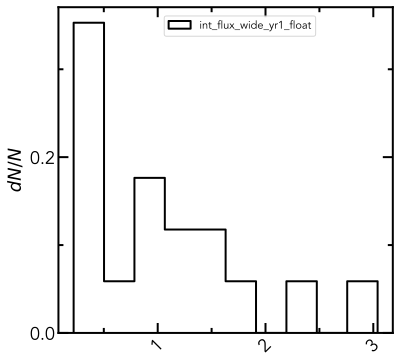

In [170]:
from adjustText import adjust_text

fig = plt.figure(figsize=(6, 6))
#fig.subplots_adjust(left=0.1, right=0.85, bottom=0.12, top=0.95)
ax=fig.add_subplot(1,1,1)

plot_label='int_flux_wide_yr1_float'
plot_data=mwa_spectral_var_table_323_mossgt36dot7_redshift

counts,bins=np.histogram(plot_data[plot_label],bins=10)

ax.hist(bins[:-1],bins,weights=counts/len(plot_data),
        fill=False,linewidth=2,histtype='step',edgecolor='black',
        label=plot_label)

set_ax_tick(ax)
set_ax_locator(ax,1.0,0.5,0.2,0.1)
#ax.set_xlim(timerangel,timeranger)
#ax.set_xlim(-2.5,2.5)
#ax.set_ylim(20,300)

ax.xaxis.set_tick_params(which='major', size=10, width=2, rotation=45,)
handles, labels = ax.get_legend_handles_labels()
hdl = handles
# remove the errorbars
#hdl = [h[0] for h in handles]
labels_dict=dict(zip(labels, hdl)) #key,values
by_label = OrderedDict(zip(labels, hdl)) 
#by_label=OrderedDict(sorted(labels_dict.items(),key=lambda t:t[0]))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.3, 0.99),
          loc=2, numpoints=1,ncol=1,fontsize=11.)

ax.set_ylabel(r'$dN/N$')
#ax.set_xlabel(r'log$L_{bol}(10^{11}L_{\odot})$')

# use them in the legend
#by_label = OrderedDict(zip(labels, handles)) 
#ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.0, 0.9),loc=2, numpoints=1, fontsize=11. )
#ax.semilogy()
#ax.semilogx()
#ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1000))
#ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(500))
#plt.title(r'$\tau$- $L_{bol}$')        

#fig.savefig('%s/tau_L_correlation.png'%png_dir,dpi=400,transparent=False,bbox_inches='tight')